In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import time
import re
import requests
import json
import tqdm

# Overview

This notebook queries the Google Maps REST API to get the service's predicted travel times between a start and end address at half hour intervals for an upcoming week. The predicted travel times are plotted for the business days.

# Query Parameters

In [2]:
waitSeconds = .05 # how long to wait between queries 
startTimeString ='2016-07-11 00:00:00'
timeZoneString = 'US/Pacific'
startTime = pd.Timestamp(startTimeString, tz=timeZoneString)
# startTime = pd.to_datetime(startTimeString)
startLocation = "20320 Estuary Lane, Newport Beach, CA"
endLocation = "4640 Admiralty Way, Marina Del Rey, CA"

In [5]:
def queryDirections(apiKey, originAddress, destinationAddress, departureDateTime=None):
    '''Queries the Google directions API given and returns the results as a json object 
    
    Inputs:
    -------
    apiKey - A string containing the Google Directions API key
    originAddress - A string representation of the origin address
    destinationAddress - A string representation of the destination address
    departureDateString - A string representation of time travel will begin in format '%Y-%m-%d %H:%M'
    
    Outputs:
    --------
    queryResult - The json object
    '''
    
    # Declare the main query string
    requestText=str('''https://maps.googleapis.com/maps/api/directions/json?'''
                        '''origin={ORIGIN}&destination={DESTINATION}'''
                        '''&departure_time={DEPARTURE_TIME}'''
                        '''&key={KEY}''')
    
    #...&traffic_model=best_guess
    
    # Clean the address strings
    def cleanAddress(rawString):
        return re.sub(' +', ' ', rawString.strip()).replace(' ', '+')
        
    originParams=cleanAddress(originAddress)
    destinationParams=cleanAddress(destinationAddress)
    
    # Clean the departure time
    def secondsSinceEpoch(departureDateTime):
        dt = departureDateTime.tz_convert('utc')
        epoch = datetime.utcfromtimestamp(0).replace(tzinfo=dt.timetz().tzinfo)
#         epoch = datetime.utcfromtimestamp(0)
        return int((dt - epoch).total_seconds())

    if departureDateTime == None:
        departureTimeParams='''now'''
    else:
        departureTimeParams=secondsSinceEpoch(departureDateTime)
        
    
    query = requestText.format(ORIGIN=originParams, 
                                  DESTINATION=destinationParams,
                                  DEPARTURE_TIME=departureTimeParams,
                                  KEY = apiKey)
#     print(query)
    
    
    # Issue query
    queryResult = requests.get(query)
    
    # Check that result is valid before returning
    assert queryResult.status_code == 200    
    jsonResult = json.loads(queryResult.content.decode())
    
    return (jsonResult)

# Get API key

In [6]:
keyPath = 'D:\data\keys\google-api.apk'

with open(keyPath) as keyFile:
    apiKey = keyFile.read()

# Trip Data from Home to Work, and Work to Home

This query loop uses the tqdm progress bar library to display how the queries are coming along.

In [7]:
# Request directions via public transit
#queryDateTime = datetime(2016, 3, 23, 6, 42, 30, 283810, 'PST')
leaveResultsList = []
returnResultsList = []
for day in tqdm.tnrange(0, 5, desc='Day loop'):
    for i in tqdm.tnrange(0, 48, desc='Hour loop'):
        queryDateTime = startTime + pd.Timedelta(days=day) + pd.Timedelta(minutes = 30*i)
        
        # Home to work
        directions_result = queryDirections (apiKey, startLocation, endLocation, departureDateTime=queryDateTime)
        assert directions_result['status'] != 'INVALID_REQUEST', directions_result['error_message']

        leaveResultsList.append([queryDateTime,
                                        directions_result['routes'][0]['legs'][0]['duration']['value'], 
                                        directions_result['routes'][0]['legs'][0]['duration_in_traffic']['value']])
        
        # Work to home
        directions_result = queryDirections (apiKey, endLocation, startLocation, departureDateTime=queryDateTime)
        assert directions_result['status'] != 'INVALID_REQUEST', directions_result['error_message']
        returnResultsList.append([queryDateTime,
                                        directions_result['routes'][0]['legs'][0]['duration']['value'], 
                                        directions_result['routes'][0]['legs'][0]['duration_in_traffic']['value']])
        time.sleep(waitSeconds)

# Clean the data

In [9]:
def cleanData(resultsList):
    df = pd.DataFrame(resultsList)
    df.columns = ['dateTime', 'durationSeconds', 'durationInTrafficSeconds']
    df['durationInTrafficMinutes'] = df.durationInTrafficSeconds / 60.
    df['dayOfWeekInt'] = df['dateTime'].dt.dayofweek
    df['dayOfWeekName'] = df['dateTime'].dt.weekday_name
    return df

dfLeaveResult = cleanData(leaveResultsList)
dfReturnResult = cleanData(returnResultsList)


# Plot travel times

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns
%matplotlib inline

tzInfo = dfLeaveResult.loc[0, 'dateTime'].tz
dateFormatter = matplotlib.dates.DateFormatter('%H:%M', tz=tzInfo)

def plotDay(df, ax, label):
    '''Plot the travel time by date
    '''
    # ax.plot_date(pd.to_datetime(plotData.timestampUNIX, unit='s'), plotData.speedOverGround, fmt='-', label=ship)
    ax.plot_date(df['dateTime'], df['durationInTrafficMinutes'], ls='-', marker='o', label=label)
    # ax[0].bar(pd.to_datetime(dfResult.datestring), dfResult.durationInTrafficMinutes, 
    #     width =.01, align='edge')
    # ax.xlabel('Time leaving home')
    # ax.ylabel('Duration in traffic (minutes)')
    
# common aesthetics
def applyCommonAesthetics(df, ax, tzInfo):
    '''Applies aesthetics to the subplot. These aesthetics seem order dependent
    '''
    
    # Locators cannot be shared between axes.
    # The set_major_locator() method assigns its axis to that Locator, 
    # overwriting any axis that was previously assigned.
    majorDateLocator = matplotlib.dates.HourLocator(byhour=range(24), interval=1, tz=tzInfo)
    minorDateLocator = matplotlib.dates.MinuteLocator(byminute=range(10, 50), interval=30, tz=tzInfo)
    
    ax.xaxis.set_major_locator(majorDateLocator)
    ax.xaxis.set_minor_locator(minorDateLocator)
    ax.xaxis.set_major_formatter(dateFormatter)
    ax.xaxis.set_minor_formatter(dateFormatter)
    
#     ax.set_xlabel('%s Time of commute start'% df['dateTime'].dt.weekday_name.tolist()[0])
#     ax.set_ylabel('Duration in traffic (minutes)')
    ax.set_ylabel('%s' % df['dateTime'].dt.weekday_name.tolist()[0])

    ax.set_ylim([df['durationInTrafficMinutes'].min() - 30, df['durationInTrafficMinutes'].max() + 30])
    
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_rotation(90)
    for tick in ax.xaxis.get_minorticklabels():
        tick.set_rotation(90)

    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    
    ax.legend(loc='best')

In [14]:
def plotLeaveReturnData(listDf, labels, subplotWidth, subplotheight):
    
    days = listDf[0]['dayOfWeekInt'].unique()
    
    fig, axes = plt.subplots(nrows=len(days), 
                             figsize=(subplotWidth,subplotHeight*len(days)))
    for row in days:
        for i, dfPlot in enumerate(listDfData):
            plotDay(dfPlot.loc[dfPlot['dayOfWeekInt'] == row], 
                    axes[row],
                   label=labels[i])

        applyCommonAesthetics(dfPlot.loc[dfPlot['dayOfWeekInt'] == row], axes[row], tzInfo)

    # Specific Aesthetics
    axes[0].set_title('Travel times')
    fig.text(0.5, 0.1, 'Time of commute start', ha='center')
    fig.text(0.04, 0.5, 'Duration of commute in traffic (minutes)', va='center', rotation='vertical')

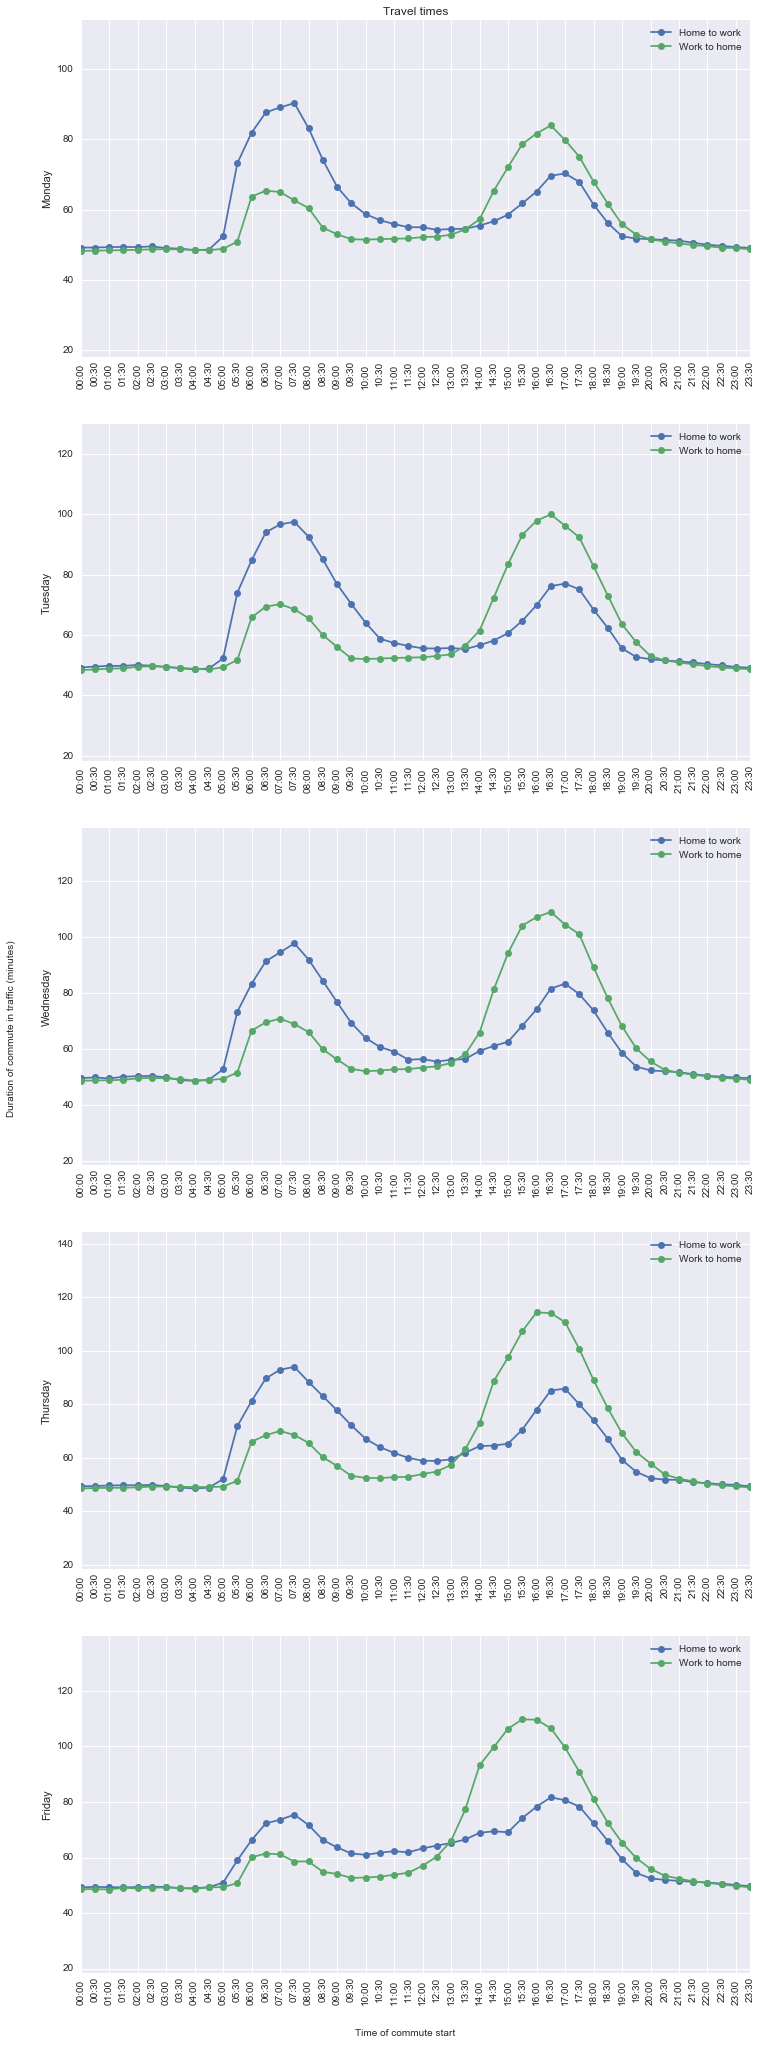

In [16]:
listDfData = [dfLeaveResult, dfReturnResult]
labels = ['Home to work', 'Work to home']
subplotWidth = 12
subplotHeight = 7

plotLeaveReturnData(listDfData, labels, subplotWidth, subplotHeight)


# Analysis

Questions:
* When are the best days to travel?
* When is the best time to leave for work?
* When is the best time to leave for home?


In [18]:
dfLeaveResult.columns

Index(['dateTime', 'durationSeconds', 'durationInTrafficSeconds',
       'durationInTrafficMinutes', 'dayOfWeekInt', 'dayOfWeekName'],
      dtype='object')

In [24]:
# When is the best day to travel?
dfLeaveResult['diffMinutes'] = dfLeaveResult.durationInTrafficMinutes.diff()
dfLeaveResult['diff2Minutes'] = dfLeaveResult.diffMinutes.diff()
dfLeaveResult.loc[:, ['dateTime', 'durationInTrafficMinutes', 'diffMinutes', 'diff2Minutes']].head()

,dateTime,durationInTrafficMinutes,diffMinutes,diff2Minutes
0,2016-07-11 00:00:00-07:00,49.216667,NaN,NaN
1,2016-07-11 00:30:00-07:00,49.250000,0.033333,NaN
2,2016-07-11 01:00:00-07:00,49.350000,0.100000,0.066667
3,2016-07-11 01:30:00-07:00,49.416667,0.066667,-0.033333
4,2016-07-11 02:00:00-07:00,49.366667,-0.050000,-0.116667


In [86]:
def findBestTravelTimes(dfTravelTimes):
    days = dfTravelTimes.dayOfWeekInt.unique()
    
    leaveResults = []
    for day in days:
        dfData = dfTravelTimes.loc[dfTravelTimes.dayOfWeekInt == day].copy()
        dfData.reset_index(drop=True, inplace=True)
        dfData['diffMinutes'] = dfData.durationInTrafficMinutes.diff()
        dfData['diff2Minutes'] = dfData.diffMinutes.diff()
        
        leaveIdx = (dfData.loc[dfData.diff2Minutes > 0, 'diffMinutes'].argmax())
#         returnIdx = (dfData.loc[dfData.diff2Minutes > 0, 'diffMinutes'][leaveIdx+1:].argmax())
        print(day, leaveIdx)
        
        leaveResults.append(dfData.loc[leaveIdx, 'dateTime'])
    
    return leaveResults

leaveTimesList = findBestTravelTimes(dfLeaveResult)

# Union new dataset that omits travel times
dfReturnSlice = pd.DataFrame()
for day in dfReturnResult.dayOfWeekInt.unique():
    dfReturnSlice = pd.concat([dfReturnSlice, 
                              dfReturnResult.loc[dfReturnResult.dayOfWeekInt == day].loc[dfReturnResult['dateTime'] > leaveTimesList[day]]])
    
returnTimesList = findBestTravelTimes(dfReturnSlice)
print(leaveTimesList)
print(returnTimesList)

0 11
1 11
2 11
3 11
4 11
0 17
1 18
2 17
3 17
4 16
[Timestamp('2016-07-11 05:30:00-0700', tz='US/Pacific'), Timestamp('2016-07-12 05:30:00-0700', tz='US/Pacific'), Timestamp('2016-07-13 05:30:00-0700', tz='US/Pacific'), Timestamp('2016-07-14 05:30:00-0700', tz='US/Pacific'), Timestamp('2016-07-15 05:30:00-0700', tz='US/Pacific')]
[Timestamp('2016-07-11 14:30:00-0700', tz='US/Pacific'), Timestamp('2016-07-12 15:00:00-0700', tz='US/Pacific'), Timestamp('2016-07-13 14:30:00-0700', tz='US/Pacific'), Timestamp('2016-07-14 14:30:00-0700', tz='US/Pacific'), Timestamp('2016-07-15 14:00:00-0700', tz='US/Pacific')]


In [64]:
# 1, 59
temp = dfLeaveResult.loc[(dfLeaveResult.dayOfWeekInt == 1),
                 ['dateTime', 'durationInTrafficMinutes', 'diffMinutes', 'diff2Minutes']]

In [69]:
temp.diffMinutes.rolling(window=1).sum()

48     0.083333
49     0.350000
50     0.200000
51     0.016667
52     0.300000
53    -0.250000
54    -0.383333
55    -0.500000
56    -0.300000
57     0.266667
58     3.350000
59    21.750000
60    10.766667
61     9.250000
62     2.633333
63     0.850000
64    -4.966667
65    -7.500000
66    -8.216667
67    -6.550000
68    -6.183333
69    -5.283333
70    -1.466667
71    -0.933333
72    -0.833333
73    -0.050000
74     0.166667
75    -0.366667
76     1.300000
77     1.550000
78     2.450000
79     4.083333
80     5.166667
81     6.300000
82     0.866667
83    -1.916667
84    -6.700000
85    -6.066667
86    -6.816667
87    -2.816667
88    -0.750000
89    -0.400000
90    -0.316667
91    -0.350000
92    -0.566667
93    -0.383333
94    -0.583333
95    -0.200000
Name: diffMinutes, dtype: float64

In [65]:
temp.loc[temp.diff2Minutes > 0]

,dateTime,durationInTrafficMinutes,diffMinutes,diff2Minutes
48,2016-07-12 00:00:00-07:00,49.200000,0.083333,0.333333
49,2016-07-12 00:30:00-07:00,49.550000,0.350000,0.266667
52,2016-07-12 02:00:00-07:00,50.066667,0.300000,0.283333
56,2016-07-12 04:00:00-07:00,48.633333,-0.300000,0.200000
57,2016-07-12 04:30:00-07:00,48.900000,0.266667,0.566667
58,2016-07-12 05:00:00-07:00,52.250000,3.350000,3.083333
59,2016-07-12 05:30:00-07:00,74.000000,21.750000,18.400000
67,2016-07-12 09:30:00-07:00,70.266667,-6.550000,1.666667
68,2016-07-12 10:00:00-07:00,64.083333,-6.183333,0.366667
69,2016-07-12 10:30:00-07:00,58.800000,-5.283333,0.900000
